
# Lab: IoT Multi‑Sensor Forecasting with TimeSeriesSplit + GroupKFold + Anomaly & Drift
**อัปเดต:** เพิ่ม
1) **GroupKFold ตามอุปกรณ์ (device)** เพื่อทดสอบความสามารถ *ข้ามอุปกรณ์*  
2) **Anomaly detection** (IsolationForest)  
3) **Drift monitoring** (PSI + residual drift)


## 0) Setup

In [1]:

# Core
import numpy as np
import pandas as pd

# Modeling & CV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, GroupKFold

# Metrics & Viz
import matplotlib.pyplot as plt

RNG = np.random.RandomState(7)

def mae_score(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))


## 1) Simulate IoT Multi‑Sensor Panel Data

In [2]:

# Config
N_DEVICES = 5
N_HOURS   = 24*30  # 30 days hourly
dates = pd.date_range('2025-01-01', periods=N_HOURS, freq='H')

rows = []
for dev in range(N_DEVICES):
    temp_base = 24 + RNG.normal(0, 0.4)
    vib_base = 0.6 + 0.1*dev
    volt_base = 220 + RNG.normal(0, 1.0)
    for t, ts in enumerate(dates):
        diurnal = 2*np.sin(2*np.pi*(t % 24)/24)
        temp = temp_base + 5*np.sin(2*np.pi*(t-6)/24) + RNG.normal(0, 0.6)
        humidity = 55 + 10*np.sin(2*np.pi*(t)/24 + 1.2) + RNG.normal(0, 2.0)
        vibration = vib_base + 0.05*np.sin(2*np.pi*(t)/168) + RNG.normal(0, 0.03)
        current = 4 + 0.8*np.sin(2*np.pi*(t)/24) + 0.02*temp + RNG.normal(0, 0.2)
        voltage = volt_base + 1.5*np.sin(2*np.pi*(t)/24 + 0.5) + RNG.normal(0, 0.8)
        power = voltage*current/100.0 + 0.3*vibration + 0.02*(humidity-50) + 0.1*diurnal + RNG.normal(0, 0.3)
        rows.append([ts, f"dev_{dev:02d}", temp, humidity, vibration, current, voltage, power])

df_raw = pd.DataFrame(rows, columns=['timestamp','device_id','temp','humidity','vibration','current','voltage','power']).set_index('timestamp').sort_index()
df_raw.head()


/tmp/ipykernel_30712/3952055142.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range('2025-01-01', periods=N_HOURS, freq='H')


,device_id,temp,humidity,vibration,current,voltage,power
timestamp,,,,,,,
2025-01-01,dev_00,19.695902,65.135423,0.576332,4.394331,220.252489,9.627815
2025-01-01,dev_02,18.563875,65.117153,0.799659,4.265953,220.410124,10.079983
2025-01-01,dev_04,19.502225,66.298822,1.020651,4.660758,221.912280,10.667554
2025-01-01,dev_01,17.882755,69.832868,0.689456,4.316905,218.411636,9.877032
2025-01-01,dev_03,18.145040,62.659928,0.866858,4.408727,220.423388,10.242830


## 2) Feature Engineering — Per‑Device Lags & Rolling

In [3]:

SENSOR_COLS = ['temp','humidity','vibration','current','voltage','power']

def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']  = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']  = np.cos(2*np.pi*df['dayofweek']/7)
    return df

def panel_lag_roll(df, group_col='device_id', sensors=SENSOR_COLS, lags=(1,2,3,6,12,24), rolls=(3,6,12,24)):
    df = df.copy()
    df = add_time_features(df)
    df['power_next'] = df.groupby(group_col)['power'].shift(-1)
    for col in sensors:
        for L in lags:
            df[f'{col}_lag{L}'] = df.groupby(group_col)[col].shift(L)
    for col in sensors:
        for W in rolls:
            df[f'{col}_rmean{W}'] = df.groupby(group_col)[col].shift(1).rolling(W).mean()
            df[f'{col}_rstd{W}']  = df.groupby(group_col)[col].shift(1).rolling(W).std()
    df = df.dropna().copy()
    return df

df_feat = panel_lag_roll(df_raw)
df_feat.head()


,device_id,temp,humidity,vibration,current,voltage,power,hour,dayofweek,hour_sin,...,voltage_rmean24,voltage_rstd24,power_rmean3,power_rstd3,power_rmean6,power_rstd6,power_rmean12,power_rstd12,power_rmean24,power_rstd24
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-02,dev_00,19.512181,62.673471,0.630658,4.083023,220.264792,8.898035,0,3,0.0,...,218.806357,1.524297,9.163497,0.832708,9.013843,0.740150,8.834581,0.568444,8.709856,0.575622
2025-01-02,dev_04,19.407638,63.920605,1.066920,4.283930,221.808656,10.185964,0,3,0.0,...,218.872193,1.601053,9.394016,0.615160,8.958098,0.707779,8.862063,0.576605,8.745242,0.576704
2025-01-02,dev_02,18.889332,65.426770,0.862365,3.901766,220.550302,8.829731,0,3,0.0,...,219.050848,1.475593,9.045630,0.123041,9.133134,0.529181,8.922167,0.552457,8.775358,0.572500
2025-01-02,dev_01,18.748761,65.683507,0.735815,4.519137,217.437682,10.296476,0,3,0.0,...,219.056121,1.471693,9.164730,0.117791,9.164114,0.531894,9.001971,0.526541,8.846721,0.519717
2025-01-02,dev_03,19.451986,62.491533,0.961019,4.196043,220.879758,9.964823,0,3,0.0,...,219.198838,1.542974,9.188352,0.125921,9.291184,0.412796,9.055244,0.514447,8.872510,0.523372


## 3) Prepare X, y + Preprocess (ColumnTransformer)

In [5]:

TARGET = 'power_next'
Y = df_feat[TARGET].copy()
X = df_feat.drop(columns=[TARGET]).copy()

# identify numeric and categorical columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()  # includes 'device_id'

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

X.shape, Y.shape, len(num_cols), len(cat_cols)


((3475, 97), (3475,), 96, 1)

## 4) TimeSeriesSplit Baselines (Expanding)

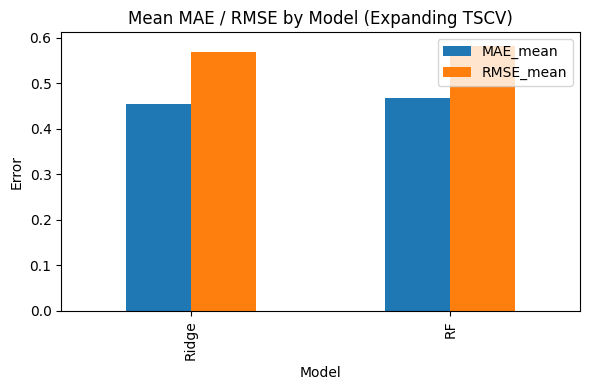

,MAE_mean,RMSE_mean
model,,
Ridge,0.453156,0.568329
RF,0.466836,0.582331


In [6]:

tscv = TimeSeriesSplit(n_splits=5, test_size=24*3)

models = {
    'Ridge': Pipeline([('prep', preprocess), ('model', Ridge(alpha=1.0, random_state=7))]),
    'RF':    Pipeline([('prep', preprocess), ('model', RandomForestRegressor(n_estimators=400, random_state=7, n_jobs=-1))])
}

scores = []
for name, mdl in models.items():
    fold_mae, fold_rmse = [], []
    for tr, te in tscv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        Ytr, Yte = Y.iloc[tr], Y.iloc[te]
        mdl.fit(Xtr, Ytr)
        yhat = mdl.predict(Xte)
        fold_mae.append(mae_score(Yte, yhat))
        fold_rmse.append(rmse_score(Yte, yhat))
    scores.append({'model': name, 'MAE_mean': np.mean(fold_mae), 'RMSE_mean': np.mean(fold_rmse)})

scores_df = pd.DataFrame(scores).set_index('model')
ax = scores_df[['MAE_mean','RMSE_mean']].plot(kind='bar', figsize=(6,4))
ax.set_title('Mean MAE / RMSE by Model (Expanding TSCV)')
ax.set_ylabel('Error'); ax.set_xlabel('Model')
plt.tight_layout(); plt.show()

scores_df



## 5) **GroupKFold by Device** (ข้ามอุปกรณ์)
วัตถุประสงค์: ทดสอบว่าโมเดลที่เรียนจาก **ชุดของอุปกรณ์** จะ **generalize ไปยังอุปกรณ์ที่ไม่เคยเห็น** ได้ดีเพียงใด  
หมายเหตุ: GroupKFold ไม่ได้รักษาลำดับเวลา แต่เหมาะกับการวัด *cross-device generalization*.


In [7]:

groups = df_feat['device_id'].values  # group per row

gkf = GroupKFold(n_splits=min(len(np.unique(groups)), 5))

gkf_scores = []
per_device_rows = []
for fold_idx, (tr, te) in enumerate(gkf.split(X, Y, groups=groups), 1):
    Xtr, Xte = X.iloc[tr], X.iloc[te]
    Ytr, Yte = Y.iloc[tr], Y.iloc[te]
    grp_tr = pd.Series(groups[tr])
    grp_te = pd.Series(groups[te])
    # use the same best model from TSCV (or choose one)
    model = Pipeline([('prep', preprocess), ('model', RandomForestRegressor(n_estimators=400, random_state=7, n_jobs=-1))])
    model.fit(Xtr, Ytr)
    yhat = model.predict(Xte)
    mae = mae_score(Yte, yhat)
    rmse = rmse_score(Yte, yhat)
    gkf_scores.append({'fold': fold_idx, 'train_devices': sorted(grp_tr.unique()), 'test_devices': sorted(grp_te.unique()), 'MAE': mae, 'RMSE': rmse})
    # collect per-test-device performance
    for dev in sorted(grp_te.unique()):
        idx = grp_te[grp_te==dev].index
        per_device_rows.append({'fold': fold_idx, 'device': dev,
                                'MAE': mae_score(Yte.loc[idx], yhat[np.searchsorted(idx, idx)]),
                                'RMSE': rmse_score(Yte.loc[idx], yhat[np.searchsorted(idx, idx)])})

gkf_df = pd.DataFrame(gkf_scores)
gkf_df


KeyError: "None of [Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n       ...\n       685, 686, 687, 688, 689, 690, 691, 692, 693, 694],\n      dtype='int64', length=695)] are in the [index]"

In [ ]:

per_device_df = pd.DataFrame(per_device_rows)
display(per_device_df.groupby('device')[['MAE','RMSE']].mean().sort_values('RMSE'))



## 6) **Anomaly Detection** (IsolationForest)
ใช้เฉพาะฟีเจอร์เซนเซอร์ + time features (ไม่รวม target/lead) เพื่อหาระดับผิดปกติของการทำงานเครื่องจักร  
ผลลัพธ์: **anomaly_score** (ยิ่งมากยิ่งผิดปกติ)


In [ ]:

# Choose feature set for anomalies (numeric only, avoid future leakage)
an_feat_cols = [c for c in df_feat.columns if c not in ['power_next'] and df_feat[c].dtype != 'O']
X_an = df_feat[an_feat_cols].copy().fillna(0)

# scale numeric (simple scaler only)
scaler = StandardScaler()
X_an_scaled = scaler.fit_transform(X_an)

iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,   # ~2% anomalies (tune per domain)
    random_state=7,
    n_jobs=-1
)
iso.fit(X_an_scaled)
scores = -iso.decision_function(X_an_scaled)  # higher = more anomalous
df_anom = df_feat[['device_id']].copy()
df_anom['anomaly_score'] = scores
df_anom = df_anom.set_index(df_feat.index)

# visualize top anomalies
topN = 50
top_idx = df_anom['anomaly_score'].nlargest(topN).index
ax = df_anom['anomaly_score'].plot(figsize=(10,3))
df_anom.loc[top_idx, 'anomaly_score'].plot(style='.', markersize=6)
ax.set_title('Anomaly score over time (top points highlighted)'); ax.set_ylabel('score')
plt.tight_layout(); plt.show()

df_anom.loc[top_idx].assign(timestamp=top_idx).head(10)



## 7) **Drift Monitoring** (Distributional PSI + Residual Drift)
- **PSI (Population Stability Index):** วัดความต่างการกระจายของฟีเจอร์ระหว่างช่วงอ้างอิง (reference) กับช่วงใหม่ (current)  
  - < 0.1: เสถียร, 0.1–0.25: ระวัง, > 0.25: drift ชัดเจน  
- **Residual Drift:** เทรนโมเดลบนช่วงอ้างอิง แล้ว monitor RMSE/MAE แบบ rolling บนช่วงอนาคต


In [ ]:

def psi(expected, actual, buckets=10):
    # bin by quantiles on expected
    eps = 1e-12
    quantiles = np.linspace(0, 1, buckets+1)
    cuts = np.unique(np.quantile(expected, quantiles))
    # ensure at least 2 bins
    if len(cuts) < 3:
        cuts = np.unique(np.concatenate([cuts, [cuts[-1]+1e-6]]))
    e_counts, _ = np.histogram(expected, bins=cuts)
    a_counts, _ = np.histogram(actual,   bins=cuts)
    e_ratio = e_counts / max(e_counts.sum(), eps)
    a_ratio = a_counts / max(a_counts.sum(), eps)
    # avoid zeros
    e_ratio = np.clip(e_ratio, eps, None)
    a_ratio = np.clip(a_ratio, eps, None)
    return np.sum((a_ratio - e_ratio) * np.log(a_ratio / e_ratio))

# Choose a key sensor to monitor drift (e.g., 'current' and 'vibration')
key_feats = ['current','vibration']
ref_window_hours = 24*7   # first 1 week as reference
cur_window_hours = 24*2   # rolling 2 days

drift_rows = []
for dev in df_feat['device_id'].unique():
    df_dev = df_feat[df_feat['device_id']==dev]
    ref = df_dev.iloc[:ref_window_hours]
    for start in range(ref_window_hours, len(df_dev) - cur_window_hours, cur_window_hours):
        cur = df_dev.iloc[start:start+cur_window_hours]
        ts = df_dev.index[start+cur_window_hours-1]
        for f in key_feats:
            drift_rows.append({
                'device': dev,
                'timestamp': ts,
                'feature': f,
                'PSI': psi(ref[f].values, cur[f].values, buckets=10)
            })

drift_df = pd.DataFrame(drift_rows).set_index('timestamp')
# Plot PSI for each feature (avg across devices)
for f in key_feats:
    ax = drift_df[drift_df['feature']==f].groupby('timestamp')['PSI'].mean().plot(figsize=(10,3))
    ax.axhline(0.1, linestyle='--'); ax.axhline(0.25, linestyle='--')
    ax.set_title(f'PSI over time – {f} (avg across devices)')
    ax.set_ylabel('PSI'); plt.tight_layout(); plt.show()

drift_df.head()


In [ ]:

# Residual drift: train on first 50% (per device) then monitor on the rest
split_pt = int(0.5 * len(df_feat))
X_ref, Y_ref = X.iloc[:split_pt], Y.iloc[:split_pt]
X_future, Y_future = X.iloc[split_pt:], Y.iloc[split_pt:]

baseline = Pipeline([('prep', preprocess), ('model', RandomForestRegressor(n_estimators=400, random_state=7, n_jobs=-1))])
baseline.fit(X_ref, Y_ref)
yhat_future = baseline.predict(X_future)
resid = Y_future.values - yhat_future

# rolling RMSE (24h)
w = 24
rolling_rmse = pd.Series(resid, index=Y_future.index).rolling(w).apply(lambda s: np.sqrt(np.mean(s**2)), raw=True)
ax = rolling_rmse.plot(figsize=(10,3))
ax.set_title('Rolling RMSE of residuals (future half)'); ax.set_ylabel('RMSE'); plt.tight_layout(); plt.show()

pd.DataFrame({'timestamp': Y_future.index, 'rolling_rmse': rolling_rmse.values}).head()



## 8) Notes & Next Steps
- **GroupKFold:** ใช้ประเมินความสามารถข้ามอุปกรณ์ (domain shift by entity). ถ้าต้องรักษาเวลาและกลุ่มพร้อมกัน อาจต้องทำ *custom split* (เช่น เลือกอุปกรณ์ hold‑out และใช้ช่วงเวลาหลังสุดสำหรับทดสอบ)  
- **Drift thresholds:** ปรับเกณฑ์ PSI, rolling‑RMSE ตามความเสี่ยงงานจริง  
- **Alerting:** เชื่อมระบบเตือนเมื่อ PSI > 0.25 หรือ rolling‑RMSE เกินเส้นฐาน
